In [1]:
from nltk.stem import SnowballStemmer
import spacy
import string
import re
from tika import parser
import os
import re
from datetime import datetime
from bs4 import BeautifulSoup
import chardet
import textract
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
from sklearn.utils.extmath import randomized_svd
import pickle
import os
import pymongo
from dotenv import load_dotenv
from datetime import datetime

nlp = spacy.load('en_core_web_lg')
punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
custom_sw = pickle.load(open('../app/data/stopwords.pkl', 'rb'))
custom_sw.extend(['want', 'cannot', 'createthelove', 'selfhealers', 'fuck'])
formats = pickle.load(open('../app/data/formats.pkl', 'rb'))

In [2]:
def get_attributes(filepath, folder):
    if not folder.endswith('/'):
        folder = folder + '/'

    file = folder + filepath
    file_stats = os.stat(file)
    attributes = {'parent_folder': folder,
                  'absolute_path': file,
                  'name': filepath,
                  'size_mb': file_stats.st_size / 1e+6,
                  'created_on': datetime.fromtimestamp(file_stats.st_birthtime),
                  'last_modified_on': datetime.fromtimestamp(file_stats.st_mtime)}

    if os.path.isdir(file):
        ext = 'folder'
    elif os.path.isfile(file):
        ext = filepath.split('.')[-1]
    else:
        ext = ''

    attributes['extension'] = ext

    return attributes


def blind_categories(format_dict, files):
    blind_classifier = {}

    for k, v in format_dict.items():
        blind_classifier[k] = [e for e in files if (e['extension'] in v)]

    blind_classifier['folders'] = [
        e for e in files if (e['extension'] == 'folder')]
    return blind_classifier


def extract_text(record, thresh=10000):
    text_ext = ['ppt', 'pptx', 'doc', 'docx', 'odt', 'pdf',
                'rtf', 'text', 'txt', 'wpd', 'ods']

    if record['extension'] in text_ext:
        text = parser.from_file(record['absolute_path'], service='text')[
            'content']
    
    if text:
        text = text.replace('\n', ' ')
        text = re.sub('[#]\w+', ' ', text)
        text = re.sub('\d+', '', text)
        for p in punctuation:
            text = text.replace(p, ' ')
        if (len(text) < thresh):
            return text
        else:
            return text[:thresh]
    
    return text


def labels(corpus, nclusters=10):
    params = {
        'vectorizer': {
            'analyzer': 'word',
            'stop_words': stopwords.words('english'),
            'ngram_range': (1, 1),
            'token_pattern': '[a-z]{3,}',
            'max_df': 0.1,
            'lowercase': True
        },
        'km_params': {
            'random_state': 30,
            'n_clusters': nclusters,
        }
    }

    tfidf = TfidfVectorizer(**params['vectorizer'])
    try:
        X = tfidf.fit_transform(corpus)
        km = KMeans(**params['km_params']).fit(X)
        return km.labels_
    except:
        return 404


def name_cluster_labels_common(sw, topic_files, words=8):

    label_text = ' '.join([file['preproc_text'] for file in topic_files])
    corpus = re.findall('[a-zA-Z]{4,}', label_text)
    corpus = [w for w in corpus if (w.lower() not in sw)]
    label_dict = Counter(corpus)
    cluster_name = '-'.join([w[0] for w in label_dict.most_common(words)])

    return cluster_name


def get_topic_files(files):
    topic_files = defaultdict(list)

    for file in files:
        topic_files[file['topic']].append(file)

    topic_files = dict(topic_files)

    return topic_files



def preprocessing(text):
    text = text.replace('\n', ' ')
    text = re.sub('[#]\w+', ' ', text)
    text = re.sub('\d+', '', text)
    for p in punctuation:
        text = text.replace(p, ' ')
    
    sent = []
    doc = nlp(text)
    
    for word in doc:
        sent.append(word.lemma_)
    
    return " ".join(sent).replace('-PRON-', '')


def stemming(text, all_stopwords=custom_sw):
    stemmer = SnowballStemmer('english', ignore_stopwords=True)
    stemmer.stopwords = all_stopwords
    
    stemmed_words = []
    
    for w in text.split():
        stemmed_words.append(stemmer.stem(w))
        
    text = ' '.join(stemmed_words)
        
    return text

# Access database

In [645]:
project_folder = os.path.expanduser(
    '/Users/faustina/METIS/BOOTCAMPWORK/Project5/controlledchaos/data/')  # the folder of your project
load_dotenv(os.path.join(project_folder, '.env'))

MONGODBNAME = os.getenv("MONGODBNAME")

client = pymongo.MongoClient()
db = client[MONGODBNAME]
curr_files_db = db['curr_files']

In [762]:
example = 'This_Directory_is_a_Mess'
folder = '/Users/faustina/Documents/{}'.format(example)
test_case = os.listdir(folder)

# Load files

In [763]:
curr_files_db.delete_many({})
curr_files_db.insert_many([get_attributes(file, folder) for file in test_case])
cursor = curr_files_db.find({})
entries = list(cursor)

# Categorization

In [764]:
files_w_attributes = entries

blind_cats = {k: list(curr_files_db.find({"extension": {"$in": v}})) for k, v in formats.items()}
blind_cats = {item: blind_cats[item] for item in sorted(blind_cats, key=lambda i: len(blind_cats[i]), reverse=True)}

# Text

1. Extraction
2. Preprocessing

    1. Remove punctuation marks
    2. Replace newline and tab characters with common spaces
    3. Lemmatize

3. Stemming (Snowball)
    1. Preserve stopwords
    2. Stem non-stopword words
    
4. Build corpus with lemmatized text
5. Convert corpus to a matrix of TF-IDF features
    1. Unigrams and Bigrams
    2. Words with more than 3 characters
    3. Terms present in at least 2 documents
    4. Terms present in at most 40% of the files analyzed

In [765]:
text_ext = ['ppt', 'pptx', 'doc', 'docx', 'odt', 'pdf',
                'rtf', 'text', 'txt', 'wpd', 'ods']

In [766]:
for file in curr_files_db.find({'extension': {"$in": text_ext}}):
    file_text = extract_text(file)
    if file_text:
        curr_files_db.update_one({'_id': file['_id']}, {"$set": {"text": file_text}})

In [767]:
for file in curr_files_db.find({'text': {"$exists": True}}):
    curr_files_db.update_one({'_id': file['_id']}, {"$set": {"preproc_text": preprocessing(file['text'])}})

In [768]:
for file in curr_files_db.find({'preproc_text': {"$exists": True}}):
    curr_files_db.update_one({'_id': file['_id']}, {"$set": {"lemma_text": stemming(file['preproc_text'])}})

In [769]:
corpus = [file['lemma_text'] for file in list(curr_files_db.find({'lemma_text': {"$exists": True}}))]

In [770]:
params = {
        'vectorizer': {
            'analyzer': 'word',
            'stop_words': custom_sw,
            'ngram_range': (1, 1),
            'token_pattern': '[a-z]{3,}',
            'min_df': 2,
            'max_df': 0.2,
            'lowercase': True
        }
    }

tfidf = TfidfVectorizer(**params['vectorizer'])

In [771]:
X_tfidf = tfidf.fit_transform(corpus)

# SVD

1. Calculate matrix decomposition to get sigma values (variance)
2. Calculate minimum optimal k to produce clusters

In [772]:
k = len(corpus)
U, Sigma, VT = randomized_svd(X_tfidf.toarray(), 
                              n_components=k,
                              n_iter=5,
                              random_state=None)

In [773]:
X_tfidf.T.shape, U.shape, Sigma.shape, VT.shape

((2819, 88), (88, 88), (88,), (88, 2819))

In [774]:
len(tfidf.get_feature_names())

2819

In [775]:
opt_k = 0

for idx, sig in enumerate(Sigma):
    if (idx + 2) < len(Sigma):
        if (str(sig)[:4] == str(Sigma[idx + 1])[:4]):
            print(sig, Sigma[idx + 1], Sigma[idx + 2])
            print(idx)
            opt_k = idx
            x = [idx]
            y = [sig]
            
            break

1.1880254055346247 1.1800155397520289 1.1616202485916962
8


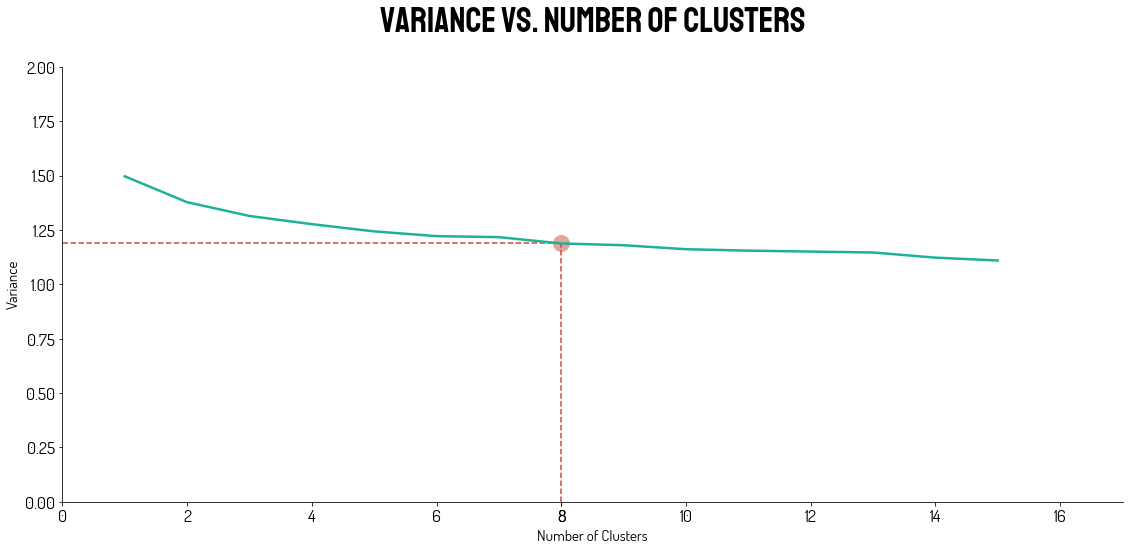

In [776]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
x_min = x[0]//4
max_vals = x[0] * 2


plt.figure(figsize=(19, 8))
ax = plt.axes()

plt.ylim((0, 2))
plt.xlim((0, max_vals + 1))


plt.title("Variance vs. Number of Clusters", size=35, pad=35, fontdict=staatliches_props)
plt.ylabel("Variance")
plt.xlabel("Number of Clusters")

sns.scatterplot(x, y, color="#C84A36", alpha=.5, legend=None, s=(300))

color = "#C84A36"
plt.vlines(x, 0, y, linestyle="dashed", colors=color)
plt.hlines(y, x, 0, linestyle="dashed", colors=color)
sns.lineplot(range(1, max_vals), Sigma[1:max_vals], color='#1fb299', linewidth=2.5)
ax.set_xticks(np.append(ax.get_xticks()[:-1], x))
sns.despine()
plt.savefig("sigma_k_{}.png".format(example), transparent=True);

# Clustering

In [777]:
X = tfidf.fit_transform(corpus)
km = KMeans(opt_k).fit(X)

In [778]:
def labels(corpus, vectorizer=tfidf, nclusters=10):
    X = tfidf.fit_transform(corpus)
    km = KMeans(n_clusters=nclusters).fit(X)
    
    return km.labels_

In [779]:
entries

[{'_id': ObjectId('5f62f2cdcf2bdcbb7c978793'),
  'parent_folder': '/Users/faustina/Documents/This_Directory_is_a_Mess/',
  'absolute_path': '/Users/faustina/Documents/This_Directory_is_a_Mess/.DS_Store',
  'name': '.DS_Store',
  'size_mb': 0.01434,
  'created_on': datetime.datetime(2020, 9, 16, 18, 56, 18),
  'last_modified_on': datetime.datetime(2020, 9, 17, 0, 10, 54),
  'extension': 'DS_Store'},
 {'_id': ObjectId('5f62f2cdcf2bdcbb7c978794'),
  'parent_folder': '/Users/faustina/Documents/This_Directory_is_a_Mess/',
  'absolute_path': '/Users/faustina/Documents/This_Directory_is_a_Mess/000021.pdf',
  'name': '000021.pdf',
  'size_mb': 0.004521,
  'created_on': datetime.datetime(2020, 9, 15, 8, 7, 26),
  'last_modified_on': datetime.datetime(2020, 9, 15, 8, 7, 26),
  'extension': 'pdf'},
 {'_id': ObjectId('5f62f2cdcf2bdcbb7c978795'),
  'parent_folder': '/Users/faustina/Documents/This_Directory_is_a_Mess/',
  'absolute_path': '/Users/faustina/Documents/This_Directory_is_a_Mess/000035.xl

In [780]:
entries = list(curr_files_db.find({"lemma_text": {"$exists": True}}))
raw_docs = [file['text'] for file in entries]
doc_labels = labels(raw_docs, vectorizer=tfidf, nclusters=opt_k)

# Update database with labels

In [781]:
for idx, entry in enumerate(entries):
    curr_files_db.update_one({'_id': entry['_id']}, {"$set": {"label": 'topic{}'.format(doc_labels[idx])}})

# Agreggation

In [782]:
km.n_clusters

8

In [783]:
topic_files = {}

for i in range(opt_k):
    entries = list(curr_files_db.find({"label": {"$exists": True}, "label": 'topic{}'.format(i)}))
    #print(Counter(' '.join([file['lemma_text'] for file in entries]).split(' ')))
    if len(entries):
        #topic_name = f"Cluster {upperletters[i]}"
        topic_files['topic{}'.format(i)] = {'topic_n': str(i), 'files': entries}
    else:
        break

In [784]:
for k, v in topic_files.items():
    [[file.pop(file_key, None) for file_key in ['_id', 'text', 'preproc_text', 'lemma_text']] for file in v['files']]

In [785]:
for idx, topic in enumerate(sorted(topic_files, key=lambda i: len(topic_files[i]['files']), reverse=True)):
    print(topic)

topic5
topic2
topic7
topic1
topic4
topic0
topic3
topic6


In [786]:
#topic_files = {f"Group {upperletters[idx]}": topic_files[item] for idx, item in enumerate(sorted(topic_files, key=lambda i: len(topic_files[i]['files']), reverse=True))}
topic_files = {f"Cluster {idx+1}": topic_files[item] for idx, item in enumerate(sorted(topic_files, key=lambda i: len(topic_files[i]['files']), reverse=True))}

In [787]:
topic_files

{'Group 1': {'topic_n': '5',
  'files': [{'parent_folder': '/Users/faustina/Documents/This_Directory_is_a_Mess/',
    'absolute_path': '/Users/faustina/Documents/This_Directory_is_a_Mess/000092.text',
    'name': '000092.text',
    'size_mb': 0.007421,
    'created_on': datetime.datetime(2020, 9, 15, 8, 7, 27),
    'last_modified_on': datetime.datetime(2020, 9, 15, 8, 7, 27),
    'extension': 'text',
    'label': 'topic5'},
   {'parent_folder': '/Users/faustina/Documents/This_Directory_is_a_Mess/',
    'absolute_path': '/Users/faustina/Documents/This_Directory_is_a_Mess/000226.text',
    'name': '000226.text',
    'size_mb': 0.192354,
    'created_on': datetime.datetime(2020, 9, 15, 8, 7, 29),
    'last_modified_on': datetime.datetime(2020, 9, 15, 8, 7, 29),
    'extension': 'text',
    'label': 'topic5'},
   {'parent_folder': '/Users/faustina/Documents/This_Directory_is_a_Mess/',
    'absolute_path': '/Users/faustina/Documents/This_Directory_is_a_Mess/000302.ppt',
    'name': '000302.

In [788]:
example

'This_Directory_is_a_Mess'

In [789]:
pickle.dump(topic_files, open('../app/data/{}.pkl'.format(example), 'wb'))

In [ ]:
topic_files